<a href="https://colab.research.google.com/github/akamwt123/FutureMakers2022/blob/main/Day_17_Computer_Vision_SV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

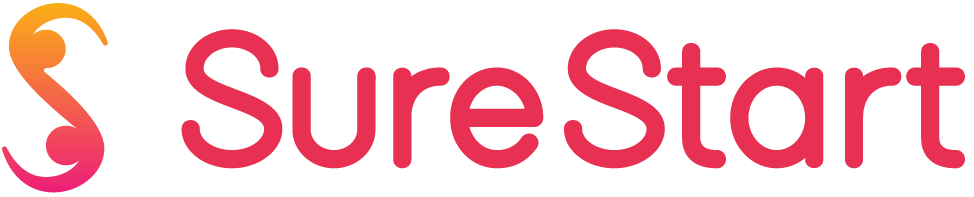

#Day 17 Objectives:
* Introduction to Computer Vision (CV) to understand how machines “see” the visual world. 
* Learn how machines can “read” your emotions by looking at your face.

#Computer Vision
Computer vision is a field of artificial intelligence (AI) that enables computers and systems to derive meaningful information from digital images, videos and other visual inputs — and take actions or make recommendations based on that information. If AI enables computers to think, computer vision enables them to see, observe and understand.

Computer vision works much the same as human vision, except humans have a head start. Human sight has the advantage of lifetimes of context to train how to tell objects apart, how far away they are, whether they are moving and whether there is something wrong in an image.

Computer vision trains machines to perform these functions, but it has to do it in much less time with cameras, data and algorithms rather than retinas, optic nerves and a visual cortex. Because a system trained to inspect products or watch a production asset can analyze thousands of products or processes a minute, noticing imperceptible defects or issues, it can quickly surpass human capabilities.


In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """


# Talking about GANs in Computer Vision
GANs are a form of neural network in which two sub-networks (the encoder and decoder) are trained on opposing loss functions: an encoder that is trained to produce data which is indiscernable from the true data, and a decoder that is trained to discern between the data and generated data.

### Load fashion-MNIST dataset

In [2]:
TRAIN_BUF=60000
BATCH_SIZE=512
TEST_BUF=10000
DIMS = (28,28,1)
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [3]:
# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

# split dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype(
    "float32"
) / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

4431872/4422102 [==============================] - 0s 0us/step


## Question 1
We have used both numpy array/pandas dataframe and tensorflow datasets. What is the difference in using either to train a model?

< *Type your answer here* >

## Answer 1

array/pandas dataframe is better for data science while tensorflow datasets are good for audio and video 

# Define the network architecture

In supervised learning, we may be interested in developing a model to predict a class label given an example of input variables.

This predictive modeling task is called classification.

Classification is also traditionally referred to as discriminative modeling.

This is because a model must discriminate examples of input variables across classes; it must choose or make a decision as to what class a given example belongs. Alternately, unsupervised models that summarize the distribution of input variables may be able to be used to create or generate new examples in the input distribution.

The GAN model architecture involves two sub-models: a generator model for generating new examples and a discriminator model for classifying whether generated examples are real, from the domain, or fake, generated by the generator model.

* **Generator**: Model that is used to generate new plausible examples from the problem domain.
* **Discriminator**: Model that is used to classify examples as real (from the domain) or fake (generated).





## Question 2
Implement a **Discriminator**.

The discriminator model takes an example from the domain as input (real or generated) and predicts a binary class label of real or fake (generated).

The real example comes from the training dataset. The generated examples are output by the generator model.

The discriminator is a well understood classification model which we have already worked on through CNNs.

After the training process, the discriminator model is discarded as we are interested in the generator.

Sometimes, the generator can be repurposed as it has learned to effectively extract features from examples in the problem domain. Some or all of the feature extraction layers can be used in transfer learning applications using the same or similar input data.

### Answer 2

Create the discriminator
It maps a 64x64 image to a binary classification score.


In [10]:
discriminator = keras.Sequential([
        keras.Input(shape=(64, 64, 3)),
        tf.keras.layers.Conv2D(512, kernel_size=4, strides=2, padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.25),
        tf.keras.layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.25),
        tf.keras.layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ], name="discriminator"
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 512)       25088     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 512)       0         
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 64, 64, 256)      2097408   
 ranspose)                                                       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64, 64, 256)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 128)       524416    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                     

## Question 3
Implement a **generator**.

The generator model takes a fixed-length random vector as input and generates a sample in the domain.

The vector is drawn from randomly from a Gaussian distribution, and the vector is used to seed the generative process. After training, points in this multidimensional vector space will correspond to points in the problem domain, forming a compressed representation of the data distribution.

This vector space is referred to as a latent space, or a vector space comprised of latent variables. Latent variables, or hidden variables, are those variables that are important for a domain but are not directly observable.

We often refer to latent variables, or a latent space, as a projection or compression of a data distribution. That is, a latent space provides a compression or high-level concepts of the observed raw data such as the input data distribution. In the case of GANs, the generator model applies meaning to points in a chosen latent space, such that new points drawn from the latent space can be provided to the generator model as input and used to generate new and different output examples.



### Answer 3
Create the generator
It mirrors the discriminator, replacing Conv2D layers with Conv2DTranspose layers.

In [11]:
latent_dim = 64

generator = keras.Sequential([
        keras.Input(shape=(latent_dim,)),
        tf.keras.layers.Dense(8 * 8 * 128),
        tf.keras.layers.Reshape((8, 8, 128)),
        tf.keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.25),
        tf.keras.layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.25),
        tf.keras.layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.25),
        tf.keras.layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ], name="generator"
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8192)              532480    
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 32, 32, 256)       0 

#Generative vs. Discriminative Algorithms
To understand GANs, you should know how generative algorithms work, and for that, contrasting them with discriminative algorithms is instructive. Discriminative algorithms try to classify input data; that is, given the features of an instance of data, they predict a label or category to which that data belongs.

For example, given all the words in an email (the data instance), a discriminative algorithm could predict whether the message is spam or not_spam. spam is one of the labels, and the bag of words gathered from the email are the features that constitute the input data. When this problem is expressed mathematically, the label is called y and the features are called x. The formulation p(y|x) is used to mean “the probability of y given x”, which in this case would translate to “the probability that an email is spam given the words it contains.”

So discriminative algorithms map features to labels. They are concerned solely with that correlation. One way to think about generative algorithms is that they do the opposite. Instead of predicting a label given certain features, they attempt to predict features given a certain label.

The question a generative algorithm tries to answer is: Assuming this email is spam, how likely are these features? While discriminative models care about the relation between y and x, generative models care about “how you get x.” They allow you to capture p(x|y), the probability of x given y, or the probability of features given a label or category. (That said, generative algorithms can also be used as classifiers. It just so happens that they can do more than categorize input data.)

Another way to think about it is to distinguish discriminative from generative like this:

* Discriminative models learn the boundary between classes
* Generative models model the distribution of individual classes

## Question 4

Do you see any similartiy or dissimilarity between Autoencoders (Encoder - Decoder) and GANs (Discriminator - Generator)? Describe. 

< *Type your answer here* >

## Answer 4

Autoencoders are semisuprivsed while GANs are unsupervised 

## Define the network as tf.keras.model object

Generative modeling is an unsupervised learning problem, as we discussed in the previous section, although a clever property of the GAN architecture is that the training of the generative model is framed as a supervised learning problem.

Let’s say we’re trying to do something more banal than mimic the Mona Lisa. We’re going to generate hand-written numerals like those found in the MNIST dataset, which is taken from the real world. The goal of the discriminator, when shown an instance from the true MNIST dataset, is to recognize those that are authentic.

Meanwhile, the generator is creating new, synthetic images that it passes to the discriminator. It does so in the hopes that they, too, will be deemed authentic, even though they are fake. The goal of the generator is to generate passable hand-written digits: to lie without being caught. The goal of the discriminator is to identify images coming from the generator as fake.

Here are the steps a GAN takes:

* The generator takes in random numbers and returns an image.
* This generated image is fed into the discriminator alongside a stream of images taken from the actual, ground-truth dataset.
* The discriminator takes in both real and fake images and returns probabilities, a number between 0 and 1, with 1 representing a prediction of authenticity and 0 representing fake.

So you have a double feedback loop:

* The discriminator is in a feedback loop with the ground truth of the images, which we know.
* The generator is in a feedback loop with the discriminator.

Here the GAN model we use incorporate two different sub-models which require us to calculate the loss for it in a different way explicitly. The  tf.keras.models.Sequential.fit() does not support this unless we structure that as tensorflow structures its loss functions. 


In [6]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

# Train the model

Create a callback that periodically saves generated images

Callbacks can be passed to keras methods such as fit, evaluate, and predict in order to hook into the various stages of the model training and inference lifecycle.

To create a custom callback, subclass keras.callbacks.Callback and override the method associated with the stage of interest. See https://www.tensorflow.org/guide/keras/custom_callback for more information.

In [7]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))

In [12]:
epochs = 1  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

gan.fit(
    train_dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)


ValueError: ignored

While we can just train the model, we also want to see what the model is learning, run the below code to plot the generated images by the GAN.

In [13]:
# exampled data for plotting results
def plot_reconstruction(model, nex=8, zm=2):
    samples = model.generator(tf.random.normal(shape=(BATCH_SIZE, latent_dim)))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(
                    samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
                )
        axs[axi].axis('off')
    plt.show()

In [ ]:
n_epochs = 100
for epoch in range(n_epochs):
    # train
    gan.fit(
    train_dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)
    if epoch%10 ==0:
      plot_reconstruction(gan)

#Talking about style transfer

Neural style transfer is an optimization technique used to take three images, a content image, a style reference image (such as an artwork by a famous painter), and the input image you want to style — and blend them together such that the input image is transformed to look like the content image, but “painted” in the style of the style image.

Style transfer consists in generating an image with the same "content" as a base image, but with the "style" of a different picture (typically artistic). This is achieved through the optimization of a loss function that has 3 components: "style loss", "content loss", and "total variation loss":

* The total variation loss imposes local spatial continuity between the pixels of the combination image, giving it visual coherence.

* The style loss is where the deep learning keeps in --that one is defined using a deep convolutional neural network. Precisely, it consists in a sum of L2 distances between the Gram matrices of the representations of the base image and the style reference image, extracted from different layers of a convnet (trained on ImageNet). The general idea is to capture color/texture information at different spatial scales (fairly large scales --defined by the depth of the layer considered).

* The content loss is a L2 distance between the features of the base image (extracted from a deep layer) and the features of the combination image, keeping the generated image close enough to the original one.

## Question 5
How are GANs and Style transfer connected?

< *Type your answer here* >

## Answer 5

GANs can be used in Style transer

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg19

base_image_path = tf.keras.utils.get_file("paris.jpg", "https://i.imgur.com/F28w3Ac.jpg")
style_reference_image_path = tf.keras.utils.get_file(
    "starry_night.jpg", "https://i.imgur.com/9ooB60I.jpg"
)
result_prefix = "paris_generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = tf.keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

950272/935806 [==============================] - 1s 1us/step


Let's take a look at our base (content) image and our style reference image


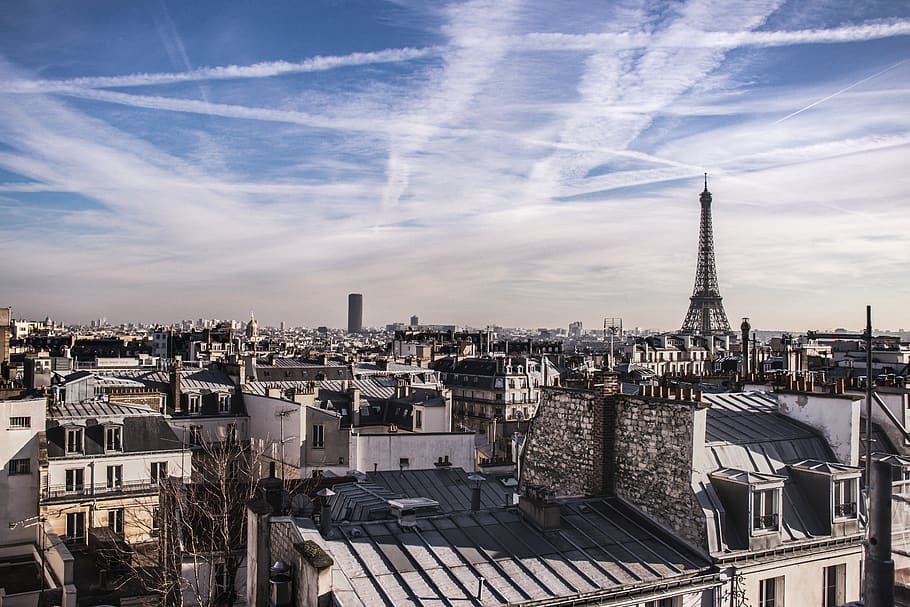

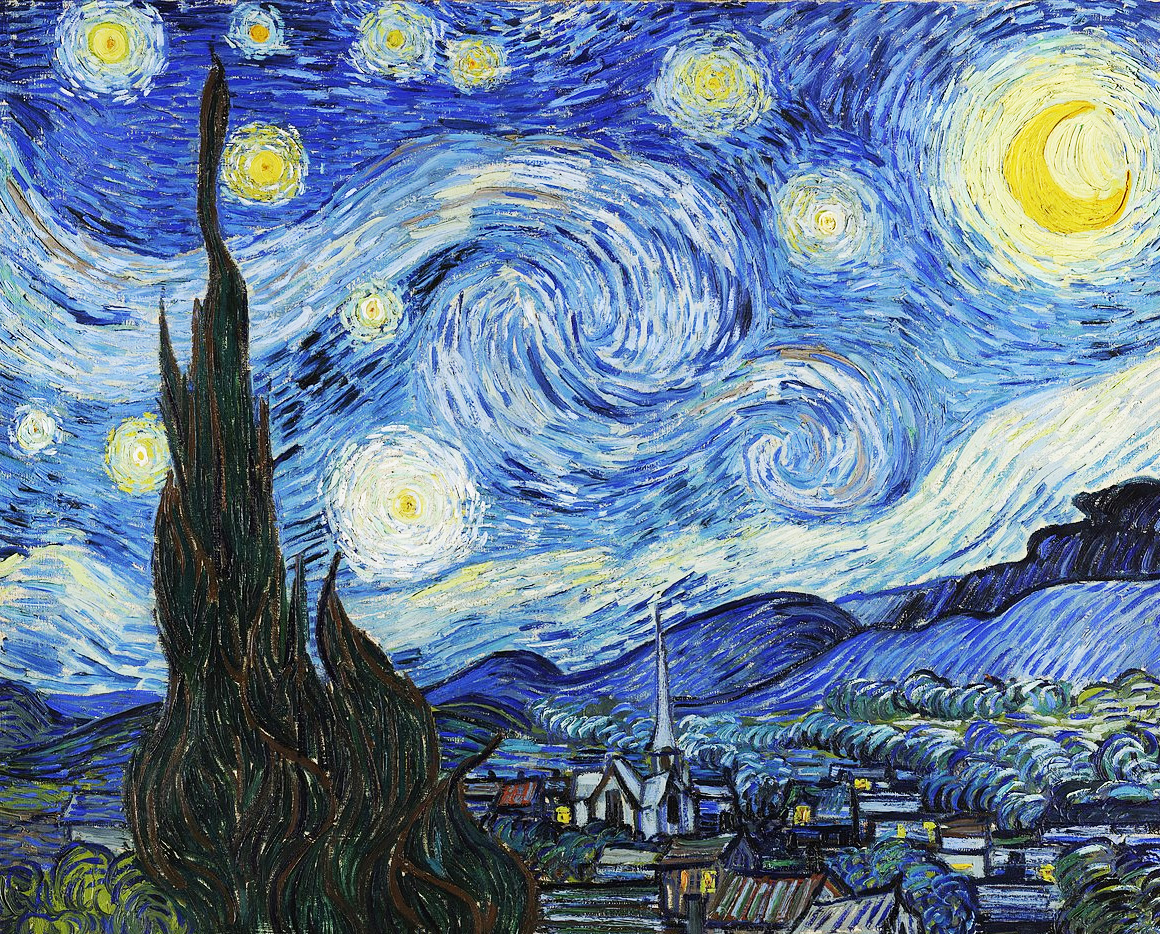

In [15]:
from IPython.display import Image, display

display(Image(base_image_path, width = 1000, height = 600))
display(Image(style_reference_image_path, width = 1000, height = 600))


# Image preprocessing/deprocessing utilities
Images need to be passed in through an tensor to process through our Deep Learning model.

But need to be in RBG numpy array to be visualized as a valid image.

In [16]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

## Question 6

Why do we not normalize the images in this case of style transfer?

< *Type your answer here* >

## Answer 6


# Explaining the various Losses

* Content Loss:

It helps to establish similarities between the content image and the generated image. It is intuitive that higher layers of the model focus more on the features present in the image i.e. overall content of the image.

Content loss is calculated by Euclidean distance between the respective intermediate higher-level feature representation of input image (x) and content image (p) at layer l.
$$L^l_{content}(p,x)=\sum_{i,j}(F_{i,j}^l(x)-P_{i,j}^l(x))$$

We perform backpropagation in the usual way such that we minimize this content loss. We thus change the initial image until it generates a similar response in a certain layer (defined in content_layer) as the original content image.
This can be implemented quite simply.

* Style loss: 

Style loss is conceptually different from Content loss. We cannot just compare the intermediate features of the two images and get the style loss. That's why we introduce a new term called Gram matrices.

Gram matrix is a way to interpret style information in an image as it shows the overall distribution of features in a given layer. It is measured as the amount of correlation present between features maps in a given layer.

Style loss is calculated by the distance between the gram matrices (or, in other terms, style representation) of the generated image and the style reference image.

The contribution of each layer in the style information is calculated by the below formula:

$$E_l = \frac{1}{4N^2_lM^2_l}\sum_{i,j}(G^l_{i,j}-A^l_{i,j})^2$$
Thus, the total style loss across each layer is expressed as:
$$L_{style}(a,x)=\sum_{l\in L}w_l E_l$$

* Total Variational loss:

Total variation loss is the sum of the absolute differences for neighboring pixel-values in the input images. This measures how much noise is in the images.

Sometimes, the learned synthesized image has a lot of high-frequency noise, i.e., particularly bright or dark pixels. One common noise reduction method is total variation denoising. Denote by  xi,j  the pixel value at coordinate  (i,j).
$$\sum_{i,j}|x_{i,j}−x_{i+1,j}|+|x_{i,j}−x_{i,j+1}|$$

More can be read at: https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-neural-style-transfer-ef88e46697ee

https://www.datacamp.com/community/tutorials/implementing-neural-style-transfer-using-tensorflow


#Compute the style transfer loss
First, we need to define 4 utility functions:

* gram_matrix (used to compute the style loss)
* The style_loss function, which keeps the generated image close to the local textures of the style reference image
* The content_loss function, which keeps the high-level representation of the generated image close to that of the base image
* The total_variation_loss function, a regularization loss which keeps the generated image locally-coherent

In [17]:
# The gram matrix of an image tensor (feature-wise outer product)

def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

# Loading a model which can determine featuers in a model
Let's create a feature extraction model that retrieves the intermediate activations of VGG19 (as a dict, by name). We use a pretrained model for its ability to determine the general patters available in imagenet dataset images.

In [18]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=outputs_dict)

80150528/80134624 [==============================] - 0s 0us/step


## Question 7
We have used the VGG19 model here. Would other models suffice? 

Why do we use a pretrained model rather than a custom model?

< *Type your answer here* >

## Answer 7

VGG16 could be used since there are less than 16 layers 

We used a pretrained model rather than a custom model because you don't have to train the model again, which saves time 

# Defining the style transfer model and computing the loss
In order to extract the content features and style features of the image, we can select the output of certain layers in the VGG network. Generally speaking, the closer to the input layer, the easier to extract details of the image, and vice versa, the easier to extract the global information of the image. In order to avoid excessively retaining the details of the content image in the synthesized image, we choose a VGG layer that is closer to the output as the content layer to output the content features of the image. We also select the output of different VGG layers for extracting local and global style features. These layers are also called style layers.The VGG network uses 5 convolutional blocks. In the experiment, we choose the last convolutional layer of the fourth convolutional block as the content layer, and the first convolutional layer of each convolutional block as the style layer. 

Finally, here's the code that computes the style transfer loss.



In [19]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

## Question 8
Why do we use different sequential models to compute style and content layers for the VGG19 model?

< *Type your answer here* >

Add a tf.function decorator to loss & gradient computation
To compile it, and thus make it fast.

In [20]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

The training loop
Repeatedly run vanilla gradient descent steps to minimize the loss, and save the resulting image every 100 iterations.

We decay the learning rate by 0.96 every 100 steps.



In [21]:
optimizer = tf.keras.optimizers.SGD(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        tf.keras.preprocessing.image.save_img(fname, img)


Iteration 100: loss=11018.20
Iteration 200: loss=8514.05
Iteration 300: loss=7571.52
Iteration 400: loss=7063.84
Iteration 500: loss=6735.87
Iteration 600: loss=6501.41
Iteration 700: loss=6323.05
Iteration 800: loss=6181.35
Iteration 900: loss=6065.45
Iteration 1000: loss=5967.92
Iteration 1100: loss=5884.81
Iteration 1200: loss=5813.12
Iteration 1300: loss=5750.80
Iteration 1400: loss=5696.20
Iteration 1500: loss=5647.89
Iteration 1600: loss=5604.81
Iteration 1700: loss=5566.16
Iteration 1800: loss=5531.33
Iteration 1900: loss=5499.78
Iteration 2000: loss=5471.12
Iteration 2100: loss=5444.98
Iteration 2200: loss=5421.04
Iteration 2300: loss=5399.01
Iteration 2400: loss=5378.76
Iteration 2500: loss=5360.08
Iteration 2600: loss=5342.85
Iteration 2700: loss=5326.88
Iteration 2800: loss=5312.03
Iteration 2900: loss=5298.21
Iteration 3000: loss=5285.38
Iteration 3100: loss=5273.41
Iteration 3200: loss=5262.24
Iteration 3300: loss=5251.79
Iteration 3400: loss=5242.00
Iteration 3500: loss=5

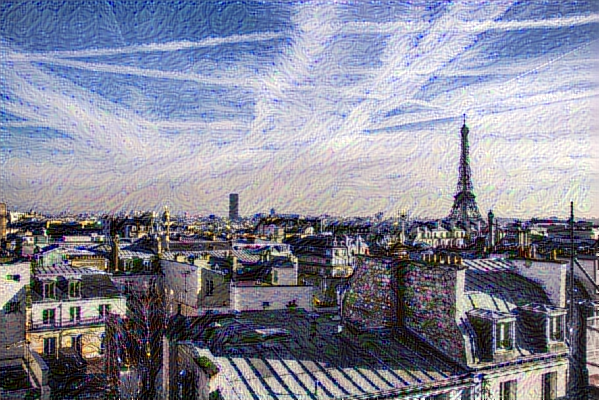

In [ ]:
for i in range(iterations//100):
  display(Image(result_prefix + "_at_iteration_"+str((i+1)*100)+".png"))


## Bonus Question 
Use different state of the art model to perform style transfer.

# **Upload this Day 17 Colab Notebook to your Github repository under "Day 17" folder. Also add your *Reflection* on today's learning in README.md**

Source: 

https://colab.research.google.com/github/timsainb/tensorflow2-generative-models/blob/master/2.0-GAN-fashion-mnist.ipynb

https://www.bpesquet.fr/mlhandbook/algorithms/neural_style_transfer.html

https://keras.io/examples/generative/neural_style_transfer/